# Tratamiento de imágenes para corregir el artefacto de desenfoque

In [1]:
import os
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage import io
import cv2 as cv

El desenfoque es un artefacto que tiene muy difícil solución y llegado a unos extremos, se antoja imposible arreglar el desenfoque, pero en el caso que vamos a tratar, un desefoque que puede ser arreglado, se utilizará la matriz de convolución que mejora la nitidez.
Esto quiere decir que se usa la energía de los píxeles vecinos para conseguir más nitidez en el pixel que se quiere cambiar para resaltar los píxeles claros y la diferencia entre píxeles claros y oscuros

Ahora se va a explicar como funciona una matriz de convolución, para ello crearemos una función para calcular la matriz de convolución resultante

In [2]:
def n_matriz_coordenadas(im,i,j):
    tama=im.shape
    if tama[0]>tama[1]:
        orden=tama[1]
    else:
        orden=tama[0]
    if (i-1>=0 & i+1<=tama[0])&(-1>=0 & j+1<=tama[1]):
        n_matriz=[im[i-1:i+1],im[j-1:j+1]]
    else:
        n_matriz=np.arange(9).reshape(3,3)
        vector=[]
        for a in range(i-1,i+2):
            for b in range(j-1,j+2):
                if i>j:
                    if (min(a,b)<0) | (max(a,b)>orden-1):
                        vector.append(0)
                    else:
                        vector.append(10)
                else:
                    if (min(a,b)<0) | (max(a,b)>orden-1):
                        vector.append(0)
                    else:
                        vector.append(10)
        vector=np.array(vector)
        n_matriz=np.array(vector).reshape(3,3)
        m=i
        for a in range(0,3):
            if n_matriz[a,0]!=0:
                n_matriz[a,0]=im[m-1,j-1]
                m+=1
            else:
                m+=1
        m=i
        for a in range(0,3):
            if n_matriz[a,1]!=0:
                n_matriz[a,1]=im[m-1,j]
                m+=1
            else:
                m+=1
        m=i
        for a in range(0,3):
            if n_matriz[a,2]!=0:
                n_matriz[a,2]=im[m-1,j+1]
                m+=1
            else:
                m+=1 

    return n_matriz

In [3]:
def convolucion3x3(im,kernel):
    tama=im.shape
    acumulado=0
    im_n=im.copy()
    for i in range(0,tama[0]):
        for j in range(0,tama[1]):
            #Usamos otra función para de apoyo para que el código sea más legible
            n_matriz=n_matriz_coordenadas(im,i,j)
            #En este punto se multiplica las matrices
            for a in range(0,3):
                for b in range(0,3):
                    acumulado=n_matriz[a,b]*kernel[a,b]+acumulado
            im_n[i,j]=acumulado
            acumulado=0
    return im_n

Ahora se va a poner a prueba este sistema.
Se conoce que la matriz de convolución para conseguir más nítidez es las siguiente:
        
        m=[[0,-1,0],[-1,5,-1],[0,-1,0]]

Se va a probar su efectividad con otra matriz de 5x5

        matriz=[[1,2,4,2,1],[3,1,1,7,2],[4,5,7,6,1],[0,1,0,3,0],[0,4,2,0,0]]
        
Una matriz de convolución funciona asignandole el valor correspondiente después de operaciones al valor que haya sido considerado como kernel.

Se muestra en la siguiente imagen como serían las operaciones.
![Explicación de convolucion](Convolucion.PNG)

In [4]:
#Se presenta una matriz de 5x5 para tratarla con la matriz de convolución
matriz=np.array([[1,2,4,2,1],[3,1,1,7,2],[4,5,7,6,1],[0,1,0,3,0],[0,4,2,0,0]])
matriz

array([[1, 2, 4, 2, 1],
       [3, 1, 1, 7, 2],
       [4, 5, 7, 6, 1],
       [0, 1, 0, 3, 0],
       [0, 4, 2, 0, 0]])

In [5]:
#El kernel o núcleo es la matriz máscara que balancee las energías 
kernel=np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
kernel

array([[ 0, -1,  0],
       [-1,  5, -1],
       [ 0, -1,  0]])

In [6]:
#Solución la convoluvión de nitidez con las funciones creadas anteriormente
convolucion=convolucion3x3(matriz,kernel)
convolucion

array([[  0,   4,  15,  -2,   1],
       [  9,  -6, -14,  24,   1],
       [ 12,  12,  23,  12,  -3],
       [ -5,  -4, -13,   9,  -4],
       [ -4,  17,   6,  -5,   0]])

La manera que se ha calculado esta convolución es haciendo cero los valores fronterizos, es decir, cuando se le aplica el núcleo en la matriz posicionada en la columna 0 y fila 0, los valores que equivaldrían a columna -1 y fila -1, columna -1 y fila 0 y columna 0 y fila -1, se le asigna un valor de 0

Ahora vamos a ver como se haría con la instrucción **signal.convolve2d** en la cual se eligirá que la matriz permanezca con las mismas dimensiones y actuando de otra manera para los valores fronterizos

In [7]:
#solución creada con la librería signal.convolve2d donde se mantiene la misma filas y columnas con la instrucción boundary='sym'
#y mode='same'
convolucion_s=signal.convolve2d(matriz,kernel,boundary='symm',mode='same')
convolucion_s

array([[ -2,   2,  11,  -4,  -1],
       [  6,  -6, -14,  24,  -1],
       [  8,  12,  23,  12,  -4],
       [ -5,  -4, -13,   9,  -4],
       [ -4,  13,   4,  -5,   0]])

Como se puede ver, los valores centrales de la matriz son los mismo, pero los de los vordes no, ya que esta función hace otro tipo de valor en la convolución

# Códico para tratar el artefacto del desenfoque

Aunque se podrían usar las otras dos funciones para calcular la matriz de convolución con un valor muy precioso en los bordes, el coste conputacional de tratar los bordes como casos especiales supera a los beneficios de obviarlos y reducior la entrada de los datos hasta la columna y fila (1,1) y la longitud de filas y columnas menos uno (fila-1,columna-1) ya que un pixel es un valor tan sumamente pequeño que apenas senotará si no se tratan los bordes y así no haciendo que el código sea extremadamente complejo y le lleve mucho tiempo calcular cada acción.

A continuación se va a crear la función más importante del código donde se alamcenarán todos los datos de la matriz tratada con la convolución almacenándolos en tres listas que representan los tres canales de una imagen de rojo, verde y azul 

In [8]:
def convolution_blur(im,coor,kernel):
    accumulated_value=0
    lista_im0=[]
    lista_im1=[]
    lista_im2=[]
    for rgb in range(0,3):
        imX=im[:,:,rgb].copy()
        for i in range(coor[1],coor[3]):
            for j in range(coor[0],coor[2]):
                matriz=imX[i-1:i+2,j-1:j+2]
                for a in range(0,3):
                    for b in range(0,3):
                        accumulated_value=matriz[a,b]*kernel[a,b]+accumulated_value
                if rgb==0:
                    lista_im0.append(accumulated_value)
                elif rgb==1:
                    lista_im1.append(accumulated_value)
                elif rgb==2:
                    lista_im2.append(accumulated_value)
                    
                accumulated_value=0
    #Se alamacena todos los datos de la matriz convolucionada en tres vectores, uno de cada canal           
    return lista_im0, lista_im1, lista_im2        

Ahora se necesita una funcion para determinar las coordenadas para aplicar la convolución donde el usuario del programa quiera conseguir esa nitidez

In [9]:
def matriz_imagen(event,x,y,flags,param):
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(im_c,(x,y),5,(0,0,255),2)
        print(f'x={x} e y={y}')

In [10]:
def gess_coordenadas():
    cv.namedWindow('Imagen')
    cv.setMouseCallback('Imagen',matriz_imagen)
    #La librería de cv2 trabajan con los canales BGR por tanto hay que cambiarlo a RGB
    im_c=cv.imread(filname,cv.COLOR_BGR2RGB)

    while True:
        im_c = cv.resize(im_c,(640,640))
        cv.imshow('Imagen',im_c)

        k=cv.waitKey(1) & 0xFF
        if k==27: #Si pulsamos esc se cierra la imagen
            break

    cv.destroyAllWindows()

Antes de nada hay que cargar la imagen que se quiere conocer los datos de manera genérica

In [11]:
def imagen(filname):
    im=io.imread(filname)
    im_c=im.copy()
    return im, im_c

In [12]:
filname='pp.jpg'
im, im_c=imagen(filname)

In [13]:
gess_coordenadas()

x=224 e y=246
x=297 e y=272


Cuando buscas las coordenadas de la imagen, aparece la foto y si pinchas click con el botón izquierdo del ratón, entonces te muestra la coordenada x y la coordenada y en pantalla. 
Pulsando la tecla "*esc*" se podrá salir de la ventana de la librería de open cv.
En la siguente imagen, se ve como se mostraría ![Ventana de Open CV](imagen_coordenadas.png)

Se necesita un control de las coordenadas para que no se metan valores no autorizado y en este caso, no se van a tratar los bordes, por tanto si se mete valores inferiores a 1 o superiores a las dimensiones de la imagen, que el resultado se corrija

In [14]:
def coordenadas(x1,y1,x2,y2,im):
    dimension=im.shape
    if (x1<1) | (x1>=x2):
        x1=1
    if (x2>dimension[1])| (x2<x1):
        x2=dimension[1]-1
    if (y1<1) | (y1>=y2):
        y1=1
    if (y2>dimension[0]-1) | (y2<y1):
        y2=dimension[0]-1
    coor=[x1, y1, x2, y2]
    print(coor)
    return coor

In [15]:
coor=coordenadas(224,246,297,272,im)

[224, 246, 297, 272]


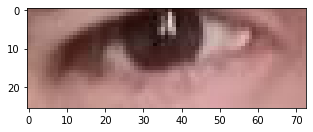

In [16]:
plt.figure(figsize=(5,5))
plt.imshow(im[coor[1]:coor[3],coor[0]:coor[2],:])

La imagen de arriba será la que se va a tratar para mejorar la nitidez de la misma

In [17]:
lista_im0, lista_im1, lista_im2=convolution_blur(im,coor,kernel)
#Una vez conseguido los datos de todos los tres canales almacenados en una lista, los convertimos en un array y 
#se unen en los tres canales
def blur_image(lista_im0, lista_im1, lista_im2,coor):
    chanel0=np.array(lista_im0)
    chanel0=chanel0.reshape(coor[3]-coor[1],coor[2]-coor[0])

    chanel1=np.array(lista_im1)
    chanel1=chanel1.reshape(coor[3]-coor[1],coor[2]-coor[0])

    chanel2=np.array(lista_im2)
    chanel2=chanel2.reshape(coor[3]-coor[1],coor[2]-coor[0])

    blur_im=[chanel0,chanel1,chanel2]
    blur_im=np.stack(blur_im,axis=2)
    #El rango de colores va de [0,255], por eso antes de convertirlo a uint8 hay que asegurarse que los valores por encima de
    #255 se hagan 255 y lo que están debajo de 0 se hagan 0
    blur_im[blur_im>255]=255
    blur_im[blur_im<0]=0
    blur_im=blur_im.astype('uint8')
    return blur_im

blur_im=blur_image(lista_im0, lista_im1, lista_im2,coor)

Ahora se mostrará la imagen del tramo que ha sido corregido con la matriz de convolución

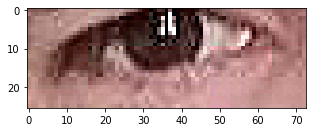

In [18]:
plt.figure(figsize=(5,5))
plt.imshow(blur_im)

In [19]:
image_correct=im.copy()
image_correct[coor[1]:coor[3],coor[0]:coor[2],:]=blur_im

En el siguiente punto podremos vor como el ojo izquierdo se ve con mucha más nitidez en la foto de la izquierda que la de la derecha

# Tratamiento del ojo izquierdo con la matriz de convolución

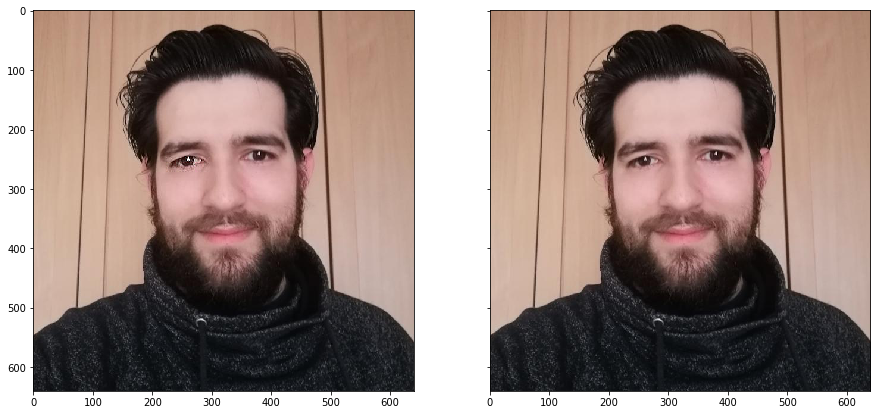

In [20]:
fig, (ax1,ax2)=plt.subplots(ncols=2,figsize=(15,15),sharex=True,sharey=True)

ax1.imshow(image_correct)
ax2.imshow(im)

ax1.set_adjustable(adjustable='box')
ax2.set_adjustable(adjustable='box')

A contuniación se procederá a corregir la nitidez por varios tramos a la imagen

Se repetirá las mismas instrucciones que se han ido realizando para darle más nitidez tanto al ojo derecho como a la boca. Además para mostrar los efectos funcionan realmente bien, ´como se puede ver, la sudara del chico de la imagentiene ciertos puntos blancos que muestran que existe desenfoque y aunque pudiese prejudicar a la foto, se tratará para demostrar como mejora sin sobrecargar la foto aplicandole el foltro de convolución a toda la foto

# Tratamiento del ojo derecho, la boca y de la sudadera

In [98]:
#Primero aparecerán las coordenadas del ojo derecho, luego de la boca y por último el tramo de la 
#sudadera con la función gess_coordenadas
gess_coordenadas()

x=337 e y=231
x=422 e y=265
x=264 e y=352
x=376 e y=394
x=171 e y=440
x=527 e y=575


[337, 237, 422, 265]


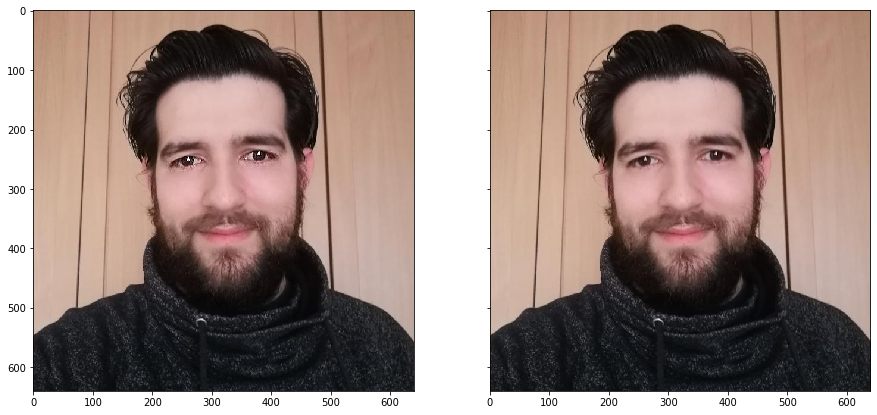

In [21]:
#Ojo derecho
coor=coordenadas(337,237,422,265,image_correct)

lista_im0, lista_im1, lista_im2=convolution_blur(image_correct,coor,kernel)

blur_im=blur_image(lista_im0, lista_im1, lista_im2,coor)

image_correct_1=image_correct.copy()
image_correct_1[coor[1]:coor[3],coor[0]:coor[2],:]=blur_im

fig, (ax1,ax2)=plt.subplots(ncols=2,figsize=(15,15),sharex=True,sharey=True)

ax1.imshow(image_correct_1)
ax2.imshow(im)

ax1.set_adjustable(adjustable='box')
ax2.set_adjustable(adjustable='box')

[264, 352, 376, 394]


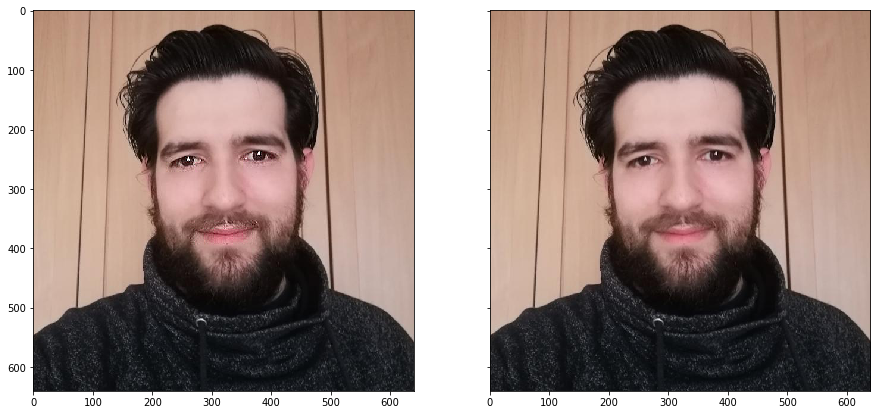

In [22]:
#Boca
coor=coordenadas(264,352,376,394,image_correct_1)

lista_im0, lista_im1, lista_im2=convolution_blur(image_correct_1,coor,kernel)

blur_im=blur_image(lista_im0, lista_im1, lista_im2,coor)

image_correct_2=image_correct_1.copy()
image_correct_2[coor[1]:coor[3],coor[0]:coor[2],:]=blur_im

fig, (ax1,ax2)=plt.subplots(ncols=2,figsize=(15,15),sharex=True,sharey=True)

ax1.imshow(image_correct_2)
ax2.imshow(im)

ax1.set_adjustable(adjustable='box')
ax2.set_adjustable(adjustable='box')

[171, 440, 527, 575]


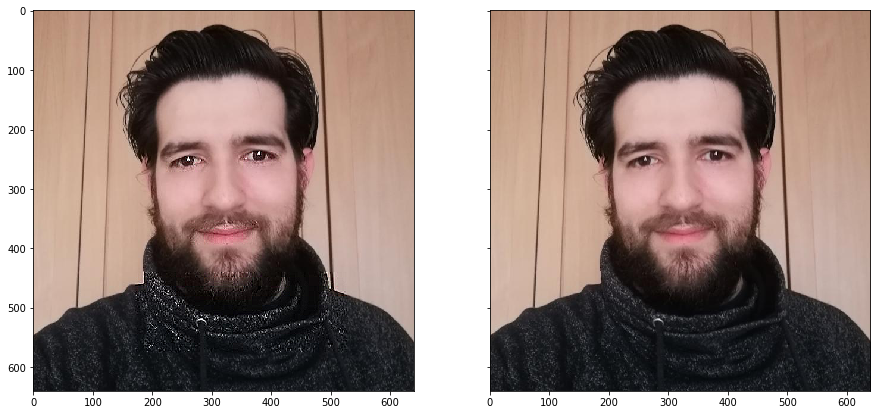

In [23]:
#Sudadera
coor=coordenadas(171,440,527,575,image_correct_2)

lista_im0, lista_im1, lista_im2=convolution_blur(image_correct_2,coor,kernel)

blur_im=blur_image(lista_im0, lista_im1, lista_im2,coor)

image_correct_3=image_correct_2.copy()
image_correct_3[coor[1]:coor[3],coor[0]:coor[2],:]=blur_im

fig, (ax1,ax2)=plt.subplots(ncols=2,figsize=(15,15),sharex=True,sharey=True)

ax1.imshow(image_correct_3)
ax2.imshow(im)

ax1.set_adjustable(adjustable='box')
ax2.set_adjustable(adjustable='box')

# Prueba de que también funciona con una segunda imagen

Ahora se va a comprobar que el código funciona con otras fotografías, y para ello se repite el proceso anterior, leyendo una segunda imagen y buscando que parte de la foto se quiere que se vea más nítida

In [118]:
filname='des.jpg'
im, im_c=imagen(filname)
gess_coordenadas()

x=30 e y=23
x=631 e y=627


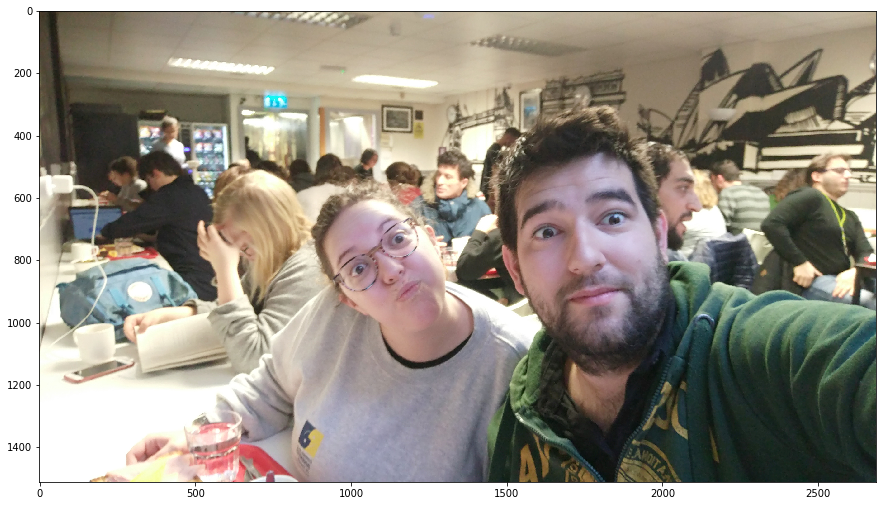

In [119]:
#Se pretende ver con mayor nitidez aplicada a toda la foto
plt.figure(figsize=(15,15))
plt.imshow(im)

De la siguiente fotografía se le aplicará el filtro completamente, así nos permitirá ver que ocurre cuando se sobreenfoca una imagen en ciertas partes y en otra el efecto de engfocar perfectamente.
Al aplicar el filtro también se genera ruido porque como ya se dijo anteriormente, el desenfoque es un artefacto que suele tener difícil solución

In [122]:
#De la fotografía se congen valores excesivamente grandes para que se aplique a toda la fotografía excepto a los bordes
coor=coordenadas(0,0,3000,3000,im)

lista_im0, lista_im1, lista_im2=convolution_blur(im,coor,kernel)

blur_im=blur_image(lista_im0, lista_im1, lista_im2,coor)

image_correct_1=im.copy()
image_correct_1[coor[1]:coor[3],coor[0]:coor[2],:]=blur_im

[1, 1, 2687, 1511]


'\n#Segunda Parte de la fotografía\ncoor=coordenadas(154,52,236,252,image_correct_1)\n\nlista_im0, lista_im1, lista_im2=convolution_blur(image_correct_1,coor,kernel)\n\nblur_im=blur_image(lista_im0, lista_im1, lista_im2,coor)\n\nimage_correct_2=image_correct_1.copy()\nimage_correct_2[coor[1]:coor[3],coor[0]:coor[2],:]=blur_im\n\n\n#Tercera parte de la fotografía\ncoor=coordenadas(447,77,600,441,image_correct_2)\n\nlista_im0, lista_im1, lista_im2=convolution_blur(image_correct_2,coor,kernel)\n\nblur_im=blur_image(lista_im0, lista_im1, lista_im2,coor)\n\nimage_correct_3=image_correct_2.copy()\nimage_correct_3[coor[1]:coor[3],coor[0]:coor[2],:]=blur_im'

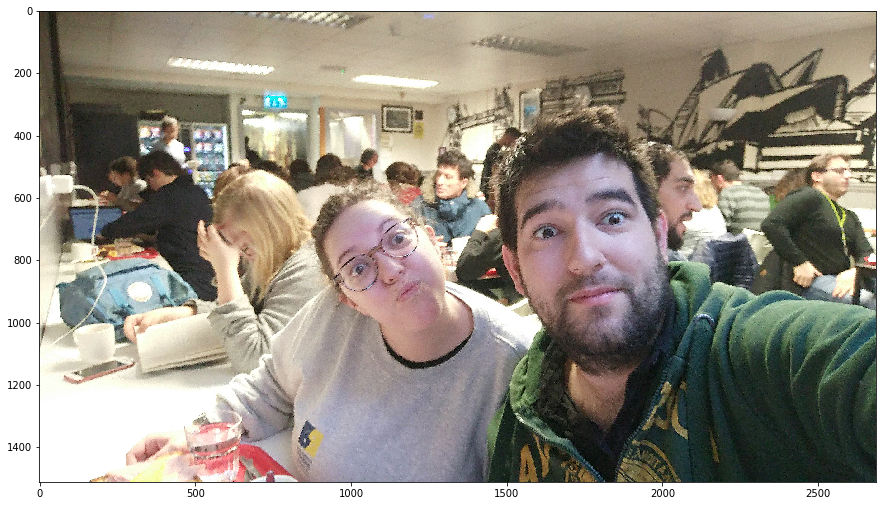

In [123]:
#Ahora se muestra la imagen ya aplicada con la matriz de convolución
plt.figure(figsize=(15,15))
plt.imshow(image_correct_1)

La cara del cicho y la chica, se puede ver como aparece sobre enfocada, pero por contra, la cara del chico que aparece en segundo plano, mejora notablemente y en la imagen de abajo, se podrá apreciar el antes y el después

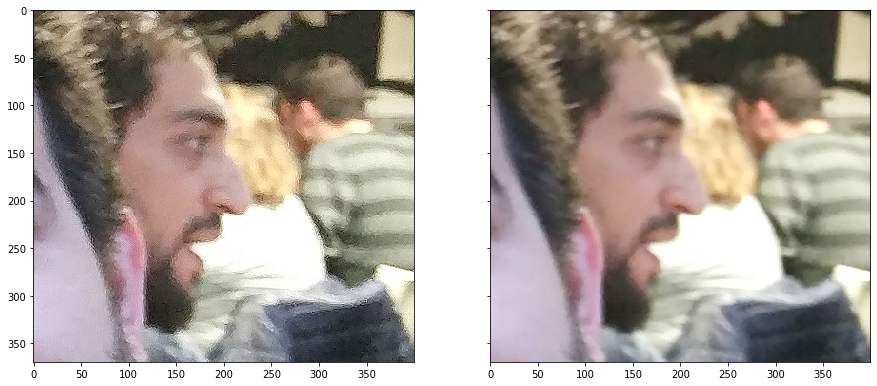

In [131]:
fig, (ax1,ax2)=plt.subplots(ncols=2,figsize=(15,15),sharex=True,sharey=True)

ax1.imshow(image_correct_1[430:800,1900:2300,:])
ax2.imshow(im[430:800,1900:2300,:])

ax1.set_adjustable(adjustable='box')
ax2.set_adjustable(adjustable='box')